### Sparse Linear Operator
This is an example of how to create and tune a sparse linear operator.

In [14]:
import torch
import matplotlib.pyplot as plt
import sparta

First, we need to create a PyTorch dense linear operator. Suppose the input feature number is K, the output feature number is N and the batch size is M.

Note that the optimal implementation and configuration are different for different batch sizes, so we need to determine the batch size at the very early stage.

In [15]:
M, K, N = 128, 3072, 768
dense_linear = torch.nn.Linear(K, N).cuda()

To build a linear operator with sparse weights, a weight mask tensor is required.

Let's generate a mask with block size $32\times32$, in which 80% of blocks are empty. 

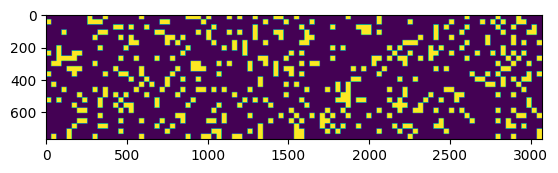

In [16]:
weight_mask = sparta.testing.block_mask((N, K), block=(32, 32), sparsity=0.8).cuda()
plt.imshow(weight_mask.cpu().numpy())

Create a ```sparta.nn.SparseLinear``` operator using the dense operator and the weight mask.

Next, tune the sparse operator using a sample input (to determine the shape). This step may take ten minutes.

In [17]:
x = torch.rand((M, K)).cuda()
sparse_linear = sparta.nn.SparseLinear(dense_linear, weight_mask=weight_mask)
sparta.nn.tune(sparse_linear, sample_inputs=[x])

[2022-11-08 16:06:56] Grid initialized, size: (2×3×3×3×2×2×2) = 432


An error occured
An error occured
An error occured
An error occured
An error occured
An error occured
An error occured
An error occured
An error occured
An error occured


KeyboardInterrupt: 

In [3]:

import sparta.specializer.kernels.matmul as sparta_matmul
sparse_matmul_kernel = sparta_matmul.SparTATemplateSparseMatMulKernel(sparse_type='sdd')
#         self.add_parameter("BLOCK_SIZE_M_VALUE", is_tunable=True, search_space=TunableItemCfg('choice', [16, 32, 64]))
#         self.add_parameter("BLOCK_SIZE_N_VALUE", is_tunable=True, search_space=TunableItemCfg('choice', [16, 32, 64]))
#         self.add_parameter("BLOCK_SIZE_K_VALUE", is_tunable=True, search_space=TunableItemCfg('choice', [16, 32, 64]))
#         self.add_parameter("THREAD_SIZE_M_VALUE", is_tunable=True, search_space=TunableItemCfg('choice', [4, 8]))
#         self.add_parameter("THREAD_SIZE_N_VALUE", is_tunable=True, search_space=TunableItemCfg('choice', [4, 8]))
#         self.add_parameter("THREAD_SIZE_K_VALUE", is_tunable=True, search_space=TunableItemCfg('choice', [4, 8]))
#

sparse_matmul_kernel.set_parameters({
  # 'M':128, 'K': 3072, 'N': 768,
  'BLOCK_SIZE_M_VALUE': 16,
    'BLOCK_SIZE_N_VALUE': 16,
    'BLOCK_SIZE_K_VALUE': 16,
  'THREAD_SIZE_M_VALUE': 4,
  'THREAD_SIZE_N_VALUE': 4,
  'THREAD_SIZE_K_VALUE': 4,
})

In [4]:
print(sparse_matmul_kernel.get_kernel_code())




const int K = None;
const int N = None;
const int BM = 16;
const int BK = 16;
const int BN = 16;
const int TM = 4;
const int TK = 4;
const int TN = 4;

__global__ void BLOCK_SPARSE_MATMUL(
    float* input_A_val,
    int* input_A_block_ptr,
    int* input_A_block_idx,
    float* input_B,
    float* input_bias,
    float* output_C
) {
    float * A_val = reinterpret_cast<float*>(input_A_val);
    int * A_block_ptr = reinterpret_cast<int*>(input_A_block_ptr);
    int * A_block_idx = reinterpret_cast<int*>(input_A_block_idx);
    float * B = reinterpret_cast<float*>(input_B);
    float * bias = reinterpret_cast<float*>(input_bias);
    float * C = reinterpret_cast<float*>(output_C);

    int by = blockIdx.y;
    int bx = blockIdx.x;
    int ty = threadIdx.y;
    int tx = threadIdx.x;

    __shared__ float As[BM * BK];
    __shared__ float Bs[BN * BK];

    float accum[TN][TM] = {0};
    float a_frag[TM][TK];
    float b_frag[TN][TK];

    int A_THREAD_PER_ROW = BK / 4;
    int B_THREAD

Let's check whether the sparse operator works correctly.

In [ ]:
sparse_weight = dense_linear.weight * weight_mask
dense_linear.load_state_dict(dict(weight=sparse_weight, bias=dense_linear.bias))
torch.testing.assert_close(sparse_linear(x), dense_linear(x))

Finally, take a look at how much time can be saved by using the sparse linear operator!

In [ ]:
dense_latency = sparta.testing.test_latency(dense_linear, inputs=[x])
print(f'Dense linear operator latency: {dense_latency} ms')
sparse_latency = sparta.testing.test_latency(sparse_linear, inputs=[x])
print(f'Sparse linear operator latency: {sparse_latency} ms')